In [1]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf
from tqdm import tqdm

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# Setup

In [2]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

# [I] Loading the data

In [3]:
scores_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\users_with_scores.parquet')
scores_ddf.head()

,n_ratings,n_reviews,uid,username,joined,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,1.144488,1.033064,2164,240,0,0,1,1
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States,2.161687,1.310320,1194,33,0,0,1,1
2,1797,1143,mdagnew.19527,mdagnew,2005-05-18 10:00:00,Northern Ireland,Northern Ireland,0.000000,0.000000,0,0,0,0,0,0
3,31,31,helloloser12345.10867,helloloser12345,2004-11-25 11:00:00,Northern Ireland,Northern Ireland,0.000000,0.000000,0,0,0,0,0,0
4,604,604,cypressbob.3708,cypressbob,2003-11-20 11:00:00,Northern Ireland,Northern Ireland,0.000000,0.000000,0,0,0,0,0,0


In [4]:
ratings_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\ratings.parquet')
ratings_ddf.head()

,date,bid,uid,rating,has_review,review,compound
0,2015-08-20 10:00:00,142544,nmann08.184925,2.88,True,"From a bottle, pours a piss yellow color with ...",0
1,2015-11-14 11:00:00,120824,nmann08.184925,3.56,False,None,0
2,2011-11-18 11:00:00,47581,nmann08.184925,4.50,False,None,0
3,2013-05-03 10:00:00,93113,nmann08.184925,3.75,False,None,0
4,2015-01-24 11:00:00,875,nmann08.184925,3.81,False,None,0


In [5]:
beers_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\beers.parquet')
beers_ddf.head()

,bid,avg_rating,review_rate,n_ratings,n_reviews
0,10.0,3.807351,0.475124,1608,764
1,100.0,3.109523,0.286713,2431,697
2,1000.0,3.801689,0.648649,148,96
3,100000.0,3.706538,0.230769,26,6
4,100001.0,3.940000,1.000000,1,1


In [6]:
scores_ddf.compute().shape

(153704, 15)

In [7]:
scores_ddf[scores_ddf["is_cfm"] == True].compute().shape

(15371, 15)

In [8]:
scores_ddf[scores_ddf["is_exp"] == True].compute().shape

(15371, 15)

In [9]:
scores_ddf[scores_ddf["is_xpl"] == True].compute().shape

(14752, 15)

In [10]:
scores_ddf[scores_ddf["is_adv"] == True].compute().shape

(13547, 15)

# [II] Sentiment analysis of each category of users

## Conformist sentiment analysis

In [11]:
from processing import sentiment_pipeline_vader
# conformist ratings
cfm_users_ddf = scores_ddf[scores_ddf["is_cfm"] == True]

# only take ratings from conformist users
cf_ratings_conformist_ddf = ratings_ddf.merge(cfm_users_ddf, on="uid", how="inner")

# only take beers with reviews
cf_ratings_conformist_ddf = cf_ratings_conformist_ddf[cf_ratings_conformist_ddf["has_review"] == True]

cf_ratings_conformist_ddf.head()



,date,bid,uid,rating,has_review,review,compound,n_ratings,n_reviews,username,...,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
4,2008-05-04 10:00:00,1778,animal69.160100,3.03,True,"on sale for $3.49 prob due to the BBD, 1/08 ; ...",0,1489,355,animal69,...,"United States, Louisiana",United States,2.96216,1.753199,82,130,1,0,1,1
5,2007-11-06 11:00:00,1275,animal69.160100,4.30,True,my fav. scotty ; pours a deep copper color w/ ...,0,1489,355,animal69,...,"United States, Louisiana",United States,2.96216,1.753199,82,130,1,0,1,1
9,2007-10-19 10:00:00,79,animal69.160100,3.90,True,I've always wanted to try this one; pours a ni...,0,1489,355,animal69,...,"United States, Louisiana",United States,2.96216,1.753199,82,130,1,0,1,1
10,2010-02-09 11:00:00,46718,animal69.160100,3.99,True,A- pours a deep brown not quite black w/ absol...,0,1489,355,animal69,...,"United States, Louisiana",United States,2.96216,1.753199,82,130,1,0,1,1
18,2007-11-01 11:00:00,576,animal69.160100,4.42,True,this is the style example i believe ; pours a ...,0,1489,355,animal69,...,"United States, Louisiana",United States,2.96216,1.753199,82,130,1,0,1,1


In [13]:
cf_ratings_conformist_ddf.compute().shape

(165640, 21)

In [12]:
cf_ratings_samples = cf_ratings_conformist_ddf.sample(frac=0.1, random_state=42)

In [13]:
cf_ratings_samples.compute().shape

(16566, 21)

In [16]:
cfm_sentiments_sample = sentiment_pipeline_vader(cf_ratings_samples)

100%|██████████| 16566/16566 [10:19<00:00, 26.73it/s]


In [17]:
cfm_sentiments_sample.head()

,date,bid,uid,rating,has_review,review,compound_sentiment
1188,2013-11-26 11:00:00,86189,jrenihan.529001,3.85,True,"Bottled June 28, 2013.Beer is very dark brown,...",0.346262
4310,2016-07-16 10:00:00,782,hat_fulla_beer.1081123,4.28,True,550ml bottle poured into Sam Adams pint glass....,0.126040
8594,2011-11-22 11:00:00,19426,kap1356.312685,3.72,True,Part of my review catch up. 2010 bottle (didn'...,0.258364
715,2012-04-21 10:00:00,79652,andrenaline.393082,3.78,True,A random I picked up on a recent visit to the ...,0.133883
8839,2011-01-13 11:00:00,782,njpink1887.299050,4.05,True,first BA review herepoured into red wine glass...,0.580150


In [18]:
# save to parquet
cfm_sentiments_sample.to_parquet('RefinedData\BeerAdvocate\\cfm_sentiments_sample.parquet')

In [ ]:
# load from parquet
cfm_sentiments_sample = ing.read_parquet('RefinedData\BeerAdvocate\sentiment_analysis\\cfm_sentiments_sample.parquet')

In [22]:
nb_pos = cfm_sentiments_sample[cfm_sentiments_sample["compound_sentiment"] > 0.05].shape[0]
nb_neg = cfm_sentiments_sample[cfm_sentiments_sample["compound_sentiment"] < -0.05].shape[0]
nb_neu = cfm_sentiments_sample[cfm_sentiments_sample["compound_sentiment"].between(-0.05, 0.05)].shape[0]

In [23]:
nb_pos, nb_neg, nb_neu

(14532, 580, 1454)

<AxesSubplot:xlabel='compound_sentiment', ylabel='Count'>

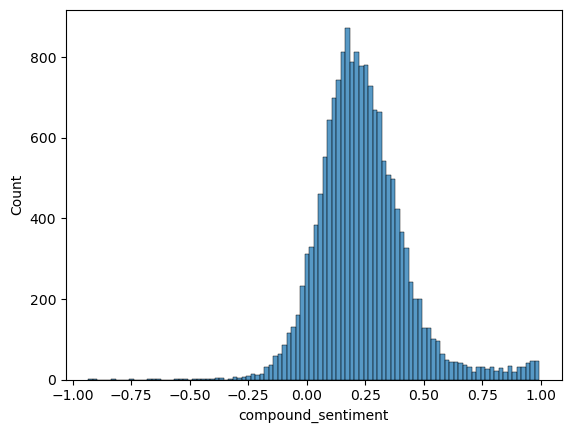

In [24]:
# plot histogram of sentiment scores
sns.histplot(cfm_sentiments_sample["compound_sentiment"], bins=100)

In [14]:
from processing import batch_sentiment_pipeline
cfm_sentiments_sample_hg = batch_sentiment_pipeline(cf_ratings_samples)

Downloading:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

  0%|          | 0/518 [00:00<?, ?it/s]

NotImplementedError: Item assignment with <class 'tuple'> not supported